# **Import Libraries and Dependencies**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import time
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import PIL
import cv2
import shutil
from sklearn.metrics import confusion_matrix, classification_report

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# **Read images from training data**

In [3]:
train_df = pd.read_csv('../input/covidx-cxr2/train.txt', sep=" ", header=None)
train_df.columns=['patient id', 'file_paths', 'labels', 'data source']
train_df=train_df.drop(['patient id', 'data source'], axis=1 )
train_df.head()

,file_paths,labels
0,ARDSSevere.png,negative
1,acute-respiratory-distress-syndrome-ards-1.jpg,negative
2,acute-respiratory-distress-syndrome-ards.jpg,negative
3,ards-secondary-to-tiger-snake-bite.png,negative
4,pneumocystis-pneumonia-2-PA.png,negative


# **Read images from test data**

In [4]:
test_df = pd.read_csv('../input/covidx-cxr2/test.txt', sep=" ", header=None)
test_df.columns=['id', 'file_paths', 'labels', 'data source' ]
test_df=test_df.drop(['id', 'data source'], axis=1 )
test_df.head()

,file_paths,labels
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive


# **Read train and test paths**

In [5]:
train_path = '../input/covidx-cxr2/train/'
test_path = '../input/covidx-cxr2/test/'
train_df['labels'].value_counts()

positive    15994
negative    13992
Name: labels, dtype: int64

# **Pick 5000 positive and 5000 negative images**

In [6]:
file_count = 5000
samples = []
for category in train_df['labels'].unique():    
    category_slice = train_df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
train_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print ( train_df['labels'].value_counts())
print (len(train_df))

positive    5000
negative    5000
Name: labels, dtype: int64
10000


# **Split the 10000 images into training and validation sets with 90% images in training and 10% validation**

In [7]:
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)
print(train_df.labels.value_counts())
print(valid_df.labels.value_counts())
print(test_df.labels.value_counts())

negative    4503
positive    4497
Name: labels, dtype: int64
positive    503
negative    497
Name: labels, dtype: int64
positive    200
negative    200
Name: labels, dtype: int64


# **Set target size of each image and batch size into which to split the images**

In [8]:
target_size=(224,224)
batch_size=64

# **Create an image data generator object from the dataset**

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
    horizontal_flip=True,
    zoom_range=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_path,
    x_col='file_paths',
    y_col='labels',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary'
)


valid_gen = test_datagen.flow_from_dataframe(
    valid_df,
    directory=train_path,
    x_col='file_paths',
    y_col='labels', 
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_path,
    x_col='file_paths',
    y_col='labels',
    target_size=target_size,
    batch_size=batch_size, 
    color_mode='rgb',
    class_mode='binary'
)

Found 9000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


# **Hyperparameter Tuning: Grid Search CV to decide learning rate and optimizer**

In [ ]:
results = {}
gs_lrs = [0.0001, 0.001, 0.01, 0.1]
gs_optimizers = ['adam', 'sgd', 'sgdm']
for l in gs_lrs:
    for gs_optimizer in gs_optimizers:
        if gs_optimizer == 'adam':
            opt = Adam(lr = l)
        elif gs_optimizer == 'sgdm':
            opt = keras.optimizers.SGD(learning_rate = l, decay=1e-6, momentum=0.9, nesterov=True)
        elif gs_optimizer == 'sgd':
            opt = keras.optimizers.SGD(learning_rate = l, decay=1e-6, momentum=0.0, nesterov=True)


        base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=(224,224,3))

        model = tf.keras.Sequential([
            base_model, 
            tf.keras.layers.GlobalAveragePooling2D(), 
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(), 
            tf.keras.layers.Dropout(0.2), 
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        # lr=0.001
        # model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy', 'Precision', 'Recall', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])


        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'Precision', 'Recall', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

        patience = 1
        stop_patience = 10
        factor = 0.5
        class TimeHistory(keras.callbacks.Callback):
            def on_train_begin(self, logs={}):
                self.times = []

            def on_epoch_begin(self, batch, logs={}):
                self.epoch_time_start = time.time()

            def on_epoch_end(self, batch, logs={}):
                self.times.append(time.time() - self.epoch_time_start)
        time_callback = TimeHistory()

        callbacks = [
            tf.keras.callbacks.ModelCheckpoint("classify_model.h5", save_best_only=True, verbose = 0),
            tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1),
            time_callback
        ]

        epochs = 10
        history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=callbacks, verbose=1)
        results[(gs_optimizer,l)] = history.history['val_accuracy'][-1]
print(results)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-11-30 19:47:37.463704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 19:47:37.464690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 19:47:37.730109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 19:47:37.731241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from 

94683136/94668760 [==============================] - 1s 0us/step


2022-11-30 19:47:46.464765: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-30 19:47:55.988368: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


57/57 [==============================] - 157s 2s/step - loss: 0.2743 - accuracy: 0.8858 - precision: 0.8907 - recall: 0.8782 - auc: 0.9551 - true_positives: 1572.0000 - true_negatives: 1617.0000 - false_positives: 193.0000 - false_negatives: 218.0000 - val_loss: 0.3369 - val_accuracy: 0.8450 - val_precision: 0.9805 - val_recall: 0.7190 - val_auc: 0.9808 - val_true_positives: 151.0000 - val_true_negatives: 187.0000 - val_false_positives: 3.0000 - val_false_negatives: 59.0000


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
57/57 [==============================] - 100s 2s/step - loss: 0.0869 - accuracy: 0.9706 - precision: 0.9688 - recall: 0.9721 - auc: 0.9949 - true_positives: 1740.0000 - true_negatives: 1754.0000 - false_positives: 56.0000 - false_negatives: 50.0000 - val_loss: 0.1866 - val_accuracy: 0.9275 - val_precision: 0.9689 - val_recall: 0.8905 - val_auc: 0.9846 - val_true_positives: 187.0000 - val_true_negatives: 184.0000 - val_false_positives: 6.0000 - val_false_negatives: 23.0000
Epoch 3/10
57/57 [==============================] - 100s 2s/step - loss: 0.0713 - accuracy: 0.9728 - precision: 0.9742 - recall: 0.9709 - auc: 0.9966 - true_positives: 1738.0000 - true_negatives: 1764.0000 - false_positives: 46.0000 - false_negatives: 52.0000 - val_loss: 0.1629 - val_accuracy: 0.9450 - val_precision: 0.9273 - val_recall: 0.9714 - val_auc: 0.9853 - val_true_positives: 204.0000 - val_true_negatives: 174.0000 - val_false_positives: 16.0000 - val_false_negatives: 6.0000
Epoch 4/10
57/57 [======

In [44]:
def plot_learning_rates(results):
    Adam =[]
    SGD = []
    SGDM = []
    
    for k,v in results.items():
        if(k[0] == 'adam'):
            Adam.append([k[1],v])
        if(k[0] == 'sgd'):
            SGD.append([k[1],v])
        if(k[0] == 'sgdm'):
            SGDM.append([k[1],v])   
    
    lrs = [x[0] for x in sorted(Adam, key = lambda x: x[0])]
    Adam = [x[1] for x in sorted(Adam, key = lambda x: x[0])]
    SGD = [x[1] for x in sorted(SGD, key = lambda x: x[0])]
    SGDM = [x[1] for x in sorted(SGDM, key = lambda x: x[0])]
      
    print(lrs, Adam, SGD, SGDM)
  
    plt.style.use('fivethirtyeight')
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(20,8))
    
    axes[0].plot(range(len(lrs)),Adam,'r',label= 'Validation Accuracy')
    axes[0].set_title('Adam')
    axes[0].set_xticks(range(len(lrs)))
    axes[0].set_xticklabels(lrs)
    axes[0].set_xlabel('Learning Rate')
    axes[0].set_ylabel('Validation Accuracy')
    axes[0].legend()  
    
    axes[1].plot (range(len(lrs)),SGD,'r',label= 'Validation Accuracy')
    axes[1].set_title('SGD')
    axes[1].set_xticks(range(len(lrs)))
    axes[1].set_xticklabels(lrs)    
    axes[1].set_xlabel('Learning Rate')
    axes[1].set_ylabel('Validation Accuracy')
    axes[1].legend() 

    axes[2].plot (range(len(lrs)),SGDM,'r',label= 'Validation Accuracy')
    axes[2].set_title('SGDM')
    axes[2].set_xticks(range(len(lrs)))
    axes[2].set_xticklabels(lrs)     
    axes[2].set_xlabel('Learning Rate')
    axes[2].set_ylabel('Validation Accuracy')
    axes[2].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

[0.0001, 0.001, 0.01, 0.1] [0.9700000286102295, 0.9649999737739563, 0.5274999737739563, 0.7325000166893005] [0.8424999713897705, 0.9125000238418579, 0.9700000286102295, 0.9750000238418579] [0.9300000071525574, 0.949999988079071, 0.9800000190734863, 0.6725000143051147]


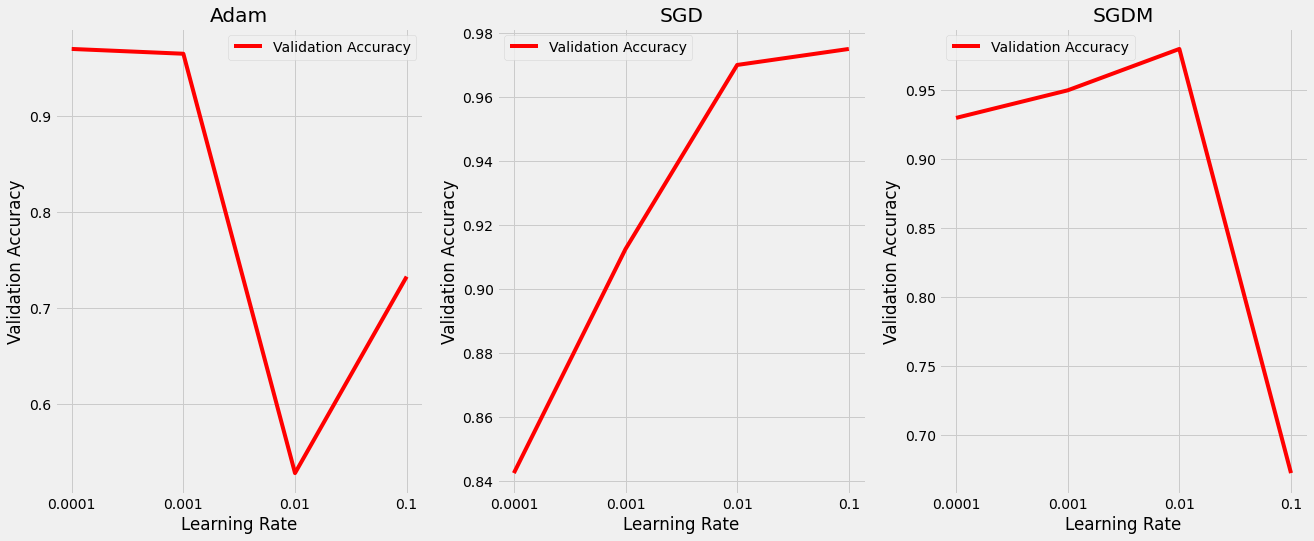

In [45]:
plot_learning_rates(results)

# **Heat Map to decide the best learning rate**

<class 'dict'>


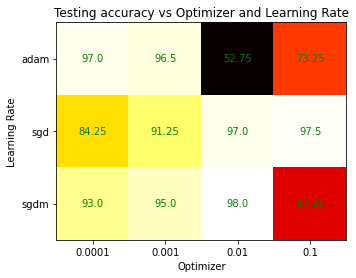

In [2]:
# Plot the results
import matplotlib.pyplot as plt
import numpy as np

dicts = {('adam', 0.0001): 0.9700000286102295, ('sgd', 0.0001): 0.8424999713897705, ('sgdm', 0.0001): 0.9300000071525574, ('adam', 0.001): 0.9649999737739563, ('sgd', 0.001): 0.9125000238418579, ('sgdm', 0.001): 0.949999988079071, ('adam', 0.01): 0.5274999737739563, ('sgd', 0.01): 0.9700000286102295, ('sgdm', 0.01): 0.9800000190734863, ('adam', 0.1): 0.7325000166893005, ('sgd', 0.1): 0.9750000238418579, ('sgdm', 0.1): 0.6725000143051147}
fig, ax = plt.subplots(1,1)

# hyper-parameters
learning_rate =  [0.0001, 0.001, 0.01, 0.1]
opt =  ['adam', 'sgd', 'sgdm']

ax.set_yticks([0, 1, 2])
ax.set_yticklabels(opt)

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(learning_rate)

arr = np.zeros([3, 4])

print(dict)

# loop over the different combinations of the hyper-parameters selected for our experiment.
for i in range(len(opt)):
    for j in range(len(learning_rate)):
        # add the values corresponding to combinations of hyper-parameters to an numpy array
        arr[i][j] = dicts[(opt[i], learning_rate[j])] * 100
        
arr = np.around(arr, 3)

plt.grid(False)
plt.xlabel('Optimizer')
plt.ylabel('Learning Rate')
plt.title('Testing accuracy vs Optimizer and Learning Rate')
plt.imshow(arr, cmap='hot', interpolation='nearest')

for (j,i),label in np.ndenumerate(arr):
    ax.text(i,j,label,ha='center',va='center', color='green')

fig.savefig('heat_map_gs_dpo_pool.png')
plt.show()

# **Train model with the best hyperparameters**

In [10]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=(224,224,3))
model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lr=0.01
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate = lr, decay=1e-6, momentum=0.9, nesterov=True), metrics=['accuracy', 'Precision', 'Recall', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

patience = 1
stop_patience = 10
factor = 0.5
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()
        
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("classify_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1),
    time_callback
]


epochs = 25
history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=callbacks, verbose=1)

2022-12-04 00:28:07.610591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 00:28:07.611578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 00:28:07.903170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 00:28:07.904339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 00:28:07.905224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

94683136/94668760 [==============================] - 0s 0us/step


2022-12-04 00:28:16.121538: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-12-04 00:28:25.673057: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


57/57 [==============================] - 171s 3s/step - loss: 0.2639 - accuracy: 0.8919 - precision: 0.9005 - recall: 0.8799 - auc: 0.9601 - true_positives: 1575.0000 - true_negatives: 1636.0000 - false_positives: 174.0000 - false_negatives: 215.0000 - val_loss: 1.0054 - val_accuracy: 0.6975 - val_precision: 0.9495 - val_recall: 0.4476 - val_auc: 0.8661 - val_true_positives: 94.0000 - val_true_negatives: 185.0000 - val_false_positives: 5.0000 - val_false_negatives: 116.0000


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
57/57 [==============================] - 101s 2s/step - loss: 0.1341 - accuracy: 0.9511 - precision: 0.9564 - recall: 0.9447 - auc: 0.9879 - true_positives: 1691.0000 - true_negatives: 1733.0000 - false_positives: 77.0000 - false_negatives: 99.0000 - val_loss: 0.2669 - val_accuracy: 0.8975 - val_precision: 0.8824 - val_recall: 0.9286 - val_auc: 0.9569 - val_true_positives: 195.0000 - val_true_negatives: 164.0000 - val_false_positives: 26.0000 - val_false_negatives: 15.0000
Epoch 3/25
57/57 [==============================] - 99s 2s/step - loss: 0.0987 - accuracy: 0.9644 - precision: 0.9695 - recall: 0.9587 - auc: 0.9934 - true_positives: 1716.0000 - true_negatives: 1756.0000 - false_positives: 54.0000 - false_negatives: 74.0000 - val_loss: 0.7799 - val_accuracy: 0.7675 - val_precision: 0.6944 - val_recall: 0.9952 - val_auc: 0.9351 - val_true_positives: 209.0000 - val_true_negatives: 98.0000 - val_false_positives: 92.0000 - val_false_negatives: 1.0000

Epoch 00003: ReduceLROnP

# **Plot the training times, training and validation loss and accuracy**

In [22]:
def tr_plot(tr_data, training_times, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    training_times_cumu = [x/60 for x in training_times]
    training_times_cumu = [sum(training_times_cumu[0:i+1]) for i in range(0,len(training_times_cumu))]
    print(training_times_cumu)
    axes[2].plot (Epochs,training_times_cumu,'r',label= 'Epoch Training Times')
    axes[2].set_title('Epoch Training Times')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Training Time (in minutes)')
    axes[2].legend()    
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

[2.55237740278244, 4.299468819300333, 6.029017980893453, 7.706488068898519, 9.348294476668041, 10.985185245672863, 12.63682589530945, 14.29533369143804, 15.919969697793325, 17.549996546904246, 19.180658662319185, 20.840755021572114, 22.486239858468377, 24.126086564858756, 25.763900967439017, 27.39992104768753, 29.01430697441101]


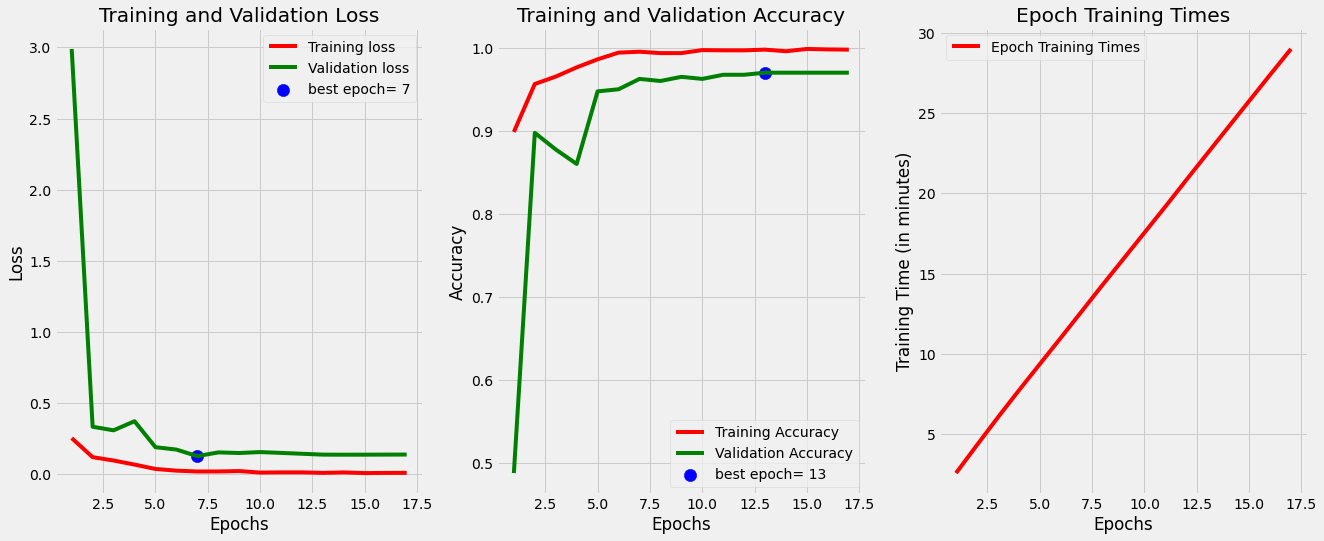

In [23]:
tr_plot(history, time_callback.times, 0)

# **Evaluate the model on the test set to calculate confusion matrix**

In [25]:
best_model = model
best_model.load_weights('./classify_model.h5')
records = best_model.evaluate(test_gen)

tr_pos, tr_neg, fl_pos, fl_neg = np.array(records[5:9])
cm = [[int(tr_neg), int(fl_pos)],
         [int(fl_neg),int(tr_pos)]]

7/7 [==============================] - 31s 5s/step - loss: 0.1528 - accuracy: 0.9325 - precision: 0.9887 - recall: 0.8750 - auc: 0.9904 - true_positives: 175.0000 - true_negatives: 198.0000 - false_positives: 2.0000 - false_negatives: 25.0000


# **Plot Confusion Matrix**

In [27]:
import seaborn as sns
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

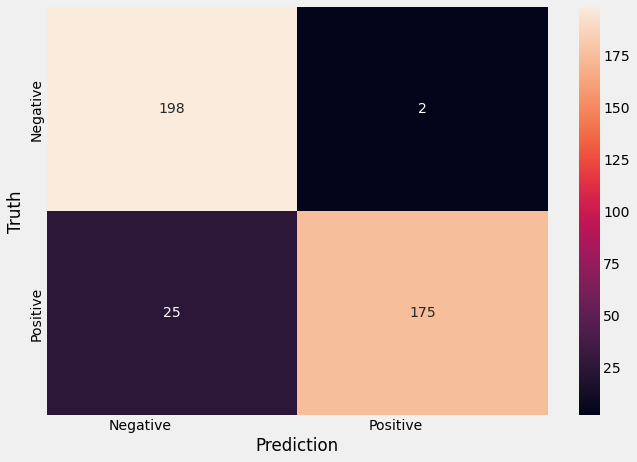

In [28]:
print_confusion_matrix(cm,["Negative","Positive"])